In [ ]:
!pip install yfinance

In [ ]:
#Para los dataframes
import pandas as pd 
#Para las operaciones
import numpy as np
#Para visualizar.
import matplotlib.pyplot as plt
#Para darle un estilo más bonito a las gráficas
import seaborn as sns
sns.set() #Con esto 'configuramos' el estilo de seaborn
#Para obtener la información de yahoo! finance
import yfinance as yf
#Para lo relacionado a estadística
from scipy.stats import norm,t

In [ ]:
MXN = yf.Ticker("MXN=X") #USD/MXN
MXN = MXN.history(start="2007-04-07",end="2022-04-07") #La fecha de término debe ser un día DESPUÉS, t+1
MXN = MXN[["Open","High","Low","Close"]]
MXN.tail()

,Open,High,Low,Close
Date,,,,
2022-04-01,19.875200,19.930059,19.750999,19.875200
2022-04-04,19.857300,19.868200,19.723101,19.857300
2022-04-05,19.809320,19.939560,19.754900,19.809320
2022-04-06,19.982599,20.074829,19.961500,19.982599
2022-04-07,20.132000,20.162300,20.122101,20.146000


#### Hay que revisar si hay na

In [ ]:
es_Na_y=MXN[pd.isna(MXN)]
renglon_tiene_Na_y = es_Na_y.any(axis=1)
renglones_con_Na_y = MXN[renglon_tiene_Na_y]
print("entradas con na",renglones_con_Na_y)
print("Hay ",len(renglones_con_Na_y), " entradas con na")
MXN=MXN.dropna()

entradas con na Empty DataFrame
Columns: [Open, High, Low, Close]
Index: []
Hay  0  entradas con na


In [ ]:
info = pd.DataFrame() #Si no lo hacemos así, tenemos un warning medio raro
info["precio"] = MXN["Close"]
info.tail() #Visualizamos

,precio
Date,
2022-04-01,19.875200
2022-04-04,19.857300
2022-04-05,19.809320
2022-04-06,19.982599
2022-04-07,20.153299


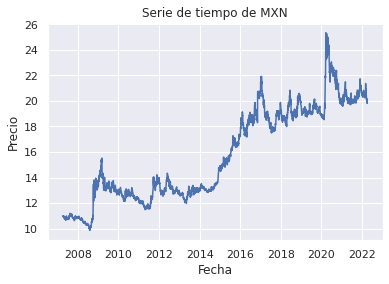

In [ ]:
plt.figure()
plt.plot(info)
plt.title('Serie de tiempo de MXN')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

## Retornos

Los retornos diarios a tienpo $t$ están dados por:

$$r_{t}^{d}=ln\left(\frac{p_t}{p_{t-1}}\right)=ln(p_t)-ln(p_{t-1})$$

Donde:

* $r_{t}^{d}$ son los retornos diarios a tiempo $t$
* $p_{t}$ es el precio a tiepo $t$
* $p_{t-1}$ es el precio a tiempo $t-1$

## En nuestro contexto: ¿Realmente son ganancias?

Estamos analizando el tipo de cambio USD/MXN, es decir, cuántos pesos necesitamos comprar para obtener un dólar.

$$USD/MXN\quad aumenta \implies \textbf{El peso se deprecia porque necesitamos más pesos para comprar un dólar}$$

$$USD/MXN\quad disminuye \implies \textbf{El peso se deprecia porque necesitamos menos pesos para comprar un dólar}$$

En este sentido, el sacar los retornos, **un retorno negativo implicará una ganancia, y uno positivo implicará una pérdida**. Entonces, estaríamos trabajando con **la distribución de pérdidas**

In [ ]:
info_diaria=info.copy() #Trabajamos con una copia del df original
info_diaria['precio_dia_anterior'] = info_diaria['precio'].shift(1) #Desplazamos una unidad hacia atrás
#Hacemos el cociente y multiplicamos por 100 para tener el porcentaje
info_diaria['retorno_diario'] = (np.log(info_diaria['precio']/info_diaria['precio_dia_anterior']))*100 
info_diaria = info_diaria.dropna()
info_diaria = info_diaria.reset_index(drop=True)
info_diaria.head()

,precio,precio_dia_anterior,retorno_diario
0,10.9978,10.9708,0.245801
1,11.0148,10.9978,0.154459
2,10.9890,11.0148,-0.234503
3,10.9410,10.9890,-0.437760
4,10.9700,10.9410,0.264710


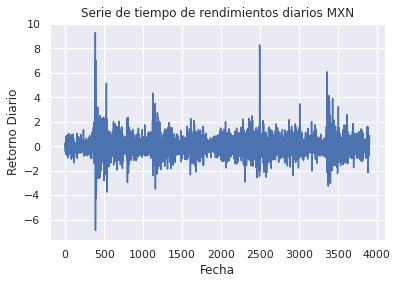

In [ ]:
plt.figure()
plt.plot(info_diaria['retorno_diario'])
plt.title('Serie de tiempo de rendimientos diarios MXN')
plt.xlabel('Fecha')
plt.ylabel('Retorno Diario')
plt.show()

## Usando t-student

In [ ]:
#info_diaria['retorno_diario']=-info_diaria['retorno_diario']
t_parameters=t.fit(info_diaria['retorno_diario'])
t_parameters

(3.548821043928611, -0.012652849068116784, 0.5573766307715138)

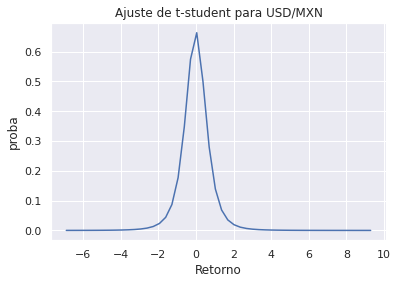

In [ ]:
x=np.linspace(min(info_diaria["retorno_diario"]),max(info_diaria["retorno_diario"]))
plt.figure()
plt.plot(x,t.pdf(x,t_parameters[0],t_parameters[1],t_parameters[2]))
plt.title('Ajuste de t-student para USD/MXN')
plt.xlabel('Retorno')
plt.ylabel('proba')
plt.show()

In [ ]:
alpha=0.995
VaR_t=t.ppf(alpha,t_parameters[0],t_parameters[1],t_parameters[2])
VaR_t

2.7906064055258653

In [ ]:
tail_loss = t.expect( lambda y: y, args = (t_parameters[0],), loc = t_parameters[1], 
                     scale = t_parameters[2], lb = VaR_t)
CVaR_t = (1 / (1 - alpha)) * tail_loss
CVaR_t

3.986287761779251

## Usando normal

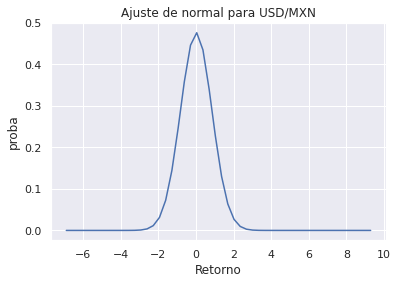

In [ ]:
mu=np.mean(info_diaria["retorno_diario"])
sigma=np.std(info_diaria["retorno_diario"])
plt.figure()
plt.plot(x,norm.pdf(x,mu,sigma))
plt.title('Ajuste de normal para USD/MXN')
plt.xlabel('Retorno')
plt.ylabel('proba')
plt.show()

In [ ]:
VaR_n=norm.ppf(alpha,mu,sigma)
VaR_n

2.171412672031679

In [ ]:
CVaR_n=mu+sigma*norm.pdf(norm.ppf(alpha,mu,sigma))/(1-alpha)
CVaR_n

6.336548063524596

## Usando el histórico

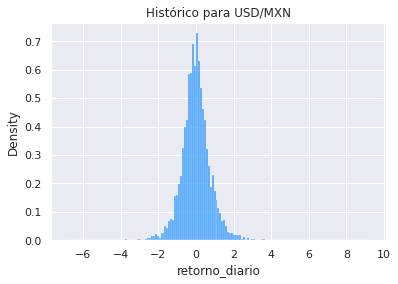

In [ ]:
plt.figure()
sns.histplot(info_diaria['retorno_diario'],stat="density",color="dodgerblue")
plt.title("Histórico para USD/MXN")
plt.show()

In [ ]:
VaR_h=np.quantile(info_diaria["retorno_diario"],alpha)
VaR_h

2.9642748207536838

In [ ]:
CVaR_h=np.mean(info_diaria[info_diaria["retorno_diario"]>=VaR_h]['retorno_diario'])
CVaR_h

4.58723555930812

Si $L\sim t(\nu,\mu,\sigma)$, entonces:

$$CVaR_{\alpha}(L)=\mu+\sigma\frac{(\nu+t^2_{\nu,\alpha})f_{\nu}(t_\nu)}{(1-\alpha)(\nu-1)}$$